Derek Lowe [blogged today](https://blogs.sciencemag.org/pipeline/archives/2019/06/20/the-most-synthetically-complex-drug-candidate-ever) about a really wild natural-product derivative that is currently a clincal candidate. I decided that I wanted to see what it looked like in 3D and, along the way, see how the coordinate generation code handles something this complex.

Here's the [original paper](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-019-45001-9/MediaObjects/41598_2019_45001_MOESM1_ESM.pdf).

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import time
import rdkit
print(rdkit.__version__)
print(time.asctime())

2019.03.2
Fri Jun 21 06:25:00 2019


Start by reading the molecule in. I redrew this from the paper, so it's easily possible I got something wrong... please let me know if you see anything off.

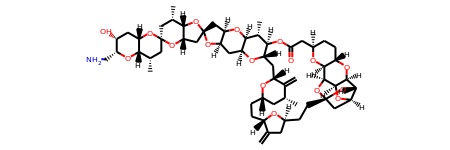

In [2]:
# we will read the molecule in and keep the Hs since they were a pain to get right:
m = Chem.MolFromMolFile('../data/E7130.mol',removeHs=False)
m

Make the drawing size a bit bigger:

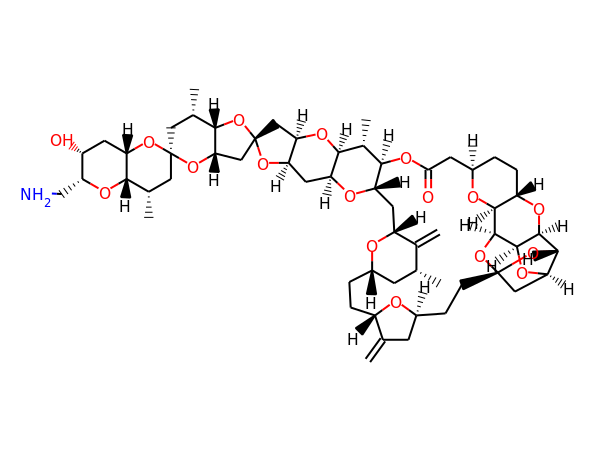

In [3]:
IPythonConsole.molSize = (600,450)
m

Start by seeing whether we perceive absolute stereo correctly or not:

In [5]:
Chem.FindMolChiralCenters(m)

[(1, 'R'),
 (2, 'R'),
 (4, 'S'),
 (5, 'S'),
 (7, 'S'),
 (9, 'R'),
 (10, 'S'),
 (13, 'S'),
 (14, 'S'),
 (17, 'S'),
 (20, 'R'),
 (21, 'R'),
 (24, 'S'),
 (25, 'S'),
 (26, 'R'),
 (28, 'S'),
 (29, 'R'),
 (35, 'R'),
 (38, 'R'),
 (39, 'S'),
 (41, 'R'),
 (42, 'S'),
 (43, 'R'),
 (46, 'R'),
 (47, 'S'),
 (49, 'R'),
 (53, 'R'),
 (55, 'S'),
 (57, 'R'),
 (63, 'S'),
 (67, 'S')]

Five of those - 26, 38, 41, 42, and 49 - disagree with Marvin. As far as I can do the CIP rules on something this complicated I believe Marvin is correct. It's not that surprising that we'd get something wrong here (the RDKit's CIP assignments are definitely only approximate), but it would be nice if it were correct.

Let's see how the RDKit's coordinate generation does with this beast:

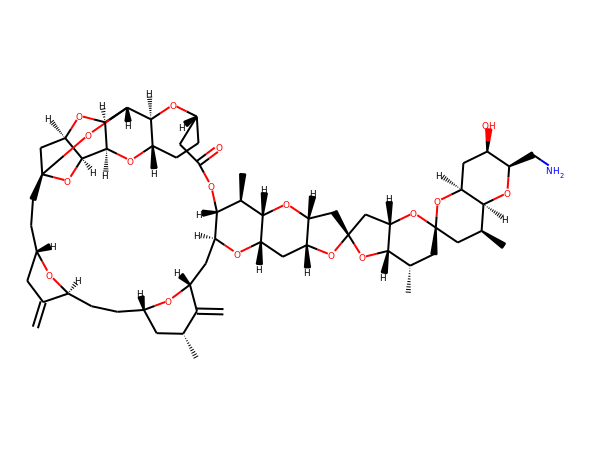

In [6]:
nm = Chem.Mol(m)
rdDepictor.Compute2DCoords(nm)
nm

That's actually better than I expected! The fused ring system isn't pretty, but you can mostly tell what the structure is.

How does CoordGen do?

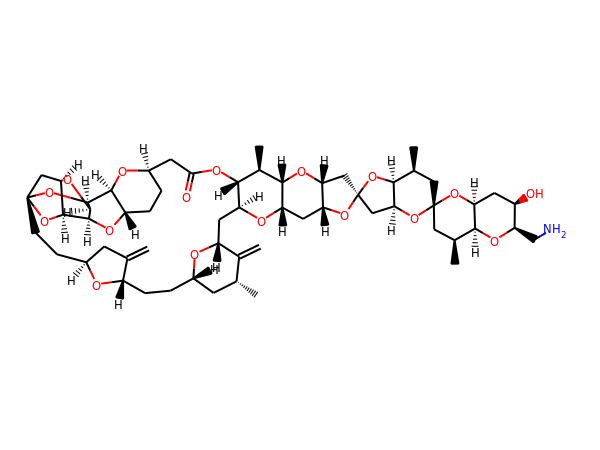

In [7]:
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(nm)
nm

There's room for improvement here. The big fused ring system at the left is hard, but it would be nice if there were less collisions, particularly of Hs.

Finally, let's take a look at it in 3D... which is what I wanted to do from the beginning:

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

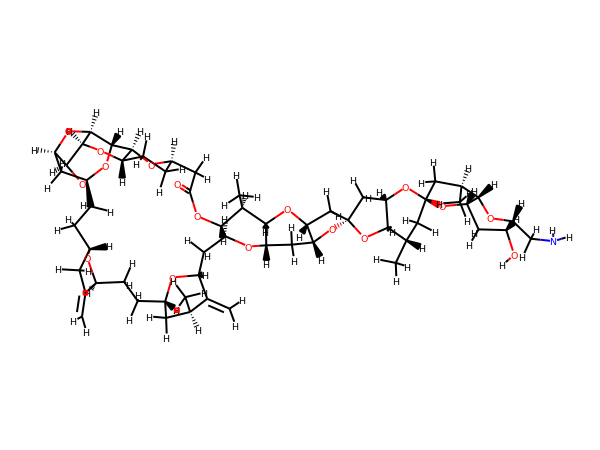

In [10]:
IPythonConsole.molSize_3d = (600,600)
mh = Chem.AddHs(m)
rdDistGeom.EmbedMolecule(mh,randomSeed=0xf00d)
mh

It is not exactly trivial to do the check, but I believe the stereochemistry matches the drawing, which is what we'd hope.

We can look and see what the RDKit's stereochemistry assignment does:

In [12]:
Chem.AssignStereochemistryFrom3D(mh)
for i,(c1,c2) in enumerate(zip(Chem.FindMolChiralCenters(mh),Chem.FindMolChiralCenters(m))):
    if c1!=c2:
        print(i,c1,c2)

14 (26, 'S') (26, 'R')
18 (38, 'S') (38, 'R')
20 (41, 'S') (41, 'R')
21 (42, 'R') (42, 'S')
25 (49, 'S') (49, 'R')


Interestingly, the centers that differ here are the ones that differed from the assignment in Marvin Sketch. After assigning the stereo from 3D we match what Marvin provides. That's something to look into.

Finally, make sure the canonical SMILES for those two molecules are the same:

In [17]:
Chem.MolToSmiles(Chem.RemoveHs(m)) == Chem.MolToSmiles(Chem.RemoveHs(mh))

True